Since diffusion-basics.ipynb became too long, starting afresh in this notebook

And trying U-net architecture again (as per Tejas' advice)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from diffusers import UNet2DModel
import matplotlib as plt

In [18]:
import wandb
# start a new wandb run to track this script


In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [20]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size 
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=img_size,            # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels to accept the conditioning information (the class)
            out_channels=1,            # the number of output channels
            layers_per_block=2,        # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),  
            down_block_types=(
                "DownBlock2D",          # a regular ResNet downsampling block
                "AttnDownBlock2D",      # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",        # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",
                "UpBlock2D",            # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_label):
        # Shape of x:
        bs, ch, w, h = x.shape
    
        # class conditioning is right shape to add as additional input channel
        class_cond = self.class_emb(class_label).view(bs, self.class_emb.embedding_dim, 1, 1)
        class_cond = class_cond.expand(bs, self.class_emb.embedding_dim, w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)
    
        # Feed the UNet with net_input, time step t, and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [21]:
import random
import matplotlib.pyplot as plt

def sample_image_multiple(num_samples=1):
    with torch.no_grad():
        # Generate initial pure Gaussian noise
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        for t in range(len(alpha_bar) - 1, -1, -1):
            z = torch.randn(num_samples, 1, 28, 28).to(device) if t > 0 else 0
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            #alpha_t_prev = alpha_bar[t - 1] if t > 0 else 1
            
            predicted_noise = model(x, torch.tensor([t/num_steps]).expand(num_samples).to(device), y)
            
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * z
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [22]:
def train(epochs=100):
    loss_ema = None
    for epoch in range(epochs):
        i = 0
        for data, labels in trainloader:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding alpha_bar_t values for each example in the batch
            alpha_bar_t = alpha_bar[t]
            
            # Generate random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # Calculate the noisy data using the reparameterization trick
            noisy_data = torch.sqrt(alpha_bar_t).view(-1, 1, 1, 1) * data + torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1) * noise
            
            predicted_noise = model(noisy_data, t/num_steps, labels)
            loss = criterion(predicted_noise, noise)
            
            loss.backward()

            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()

            wandb.log({"latest_loss": loss.item(), "avg_running_loss": loss_ema}, step=epoch * len(trainloader) + i)
            
            optimizer.step()
            
            if (i % 50) == 0:
                print(f"Epoch [{epoch+1}/1000], i: {i}, Loss: {loss.item():.4f}, Running loss: {loss_ema}")
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4)

    wandb.finish()

In [23]:
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
# Generate the beta values linearly from beta_start to beta_end
beta = torch.linspace(beta_start, beta_end, num_steps).to(device)
sqrt_beta = torch.sqrt(beta)

alpha = 1 - beta
log_alpha  = torch.log(alpha)

# Pre-calculate alpha_bar_t for all timesteps
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar_v2 = torch.cumsum(log_alpha,dim=0).exp()

sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_alpha_bar_v2 = torch.sqrt(alpha_bar_v2)

In [24]:
alpha_bar

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [25]:
alpha_bar_v2

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [26]:
sqrt_alpha_bar, sqrt_alpha_bar_v2

(tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996, 0.9994, 0.9993, 0.9992,
         0.9991, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.9980, 0.9978, 0.9976,
         0.9973, 0.9971, 0.9969, 0.9966, 0.9963, 0.9961, 0.9958, 0.9955, 0.9952,
         0.9948, 0.9945, 0.9942, 0.9938, 0.9935, 0.9931, 0.9927, 0.9924, 0.9920,
         0.9916, 0.9911, 0.9907, 0.9903, 0.9898, 0.9894, 0.9889, 0.9884, 0.9880,
         0.9875, 0.9870, 0.9865, 0.9859, 0.9854, 0.9849, 0.9843, 0.9838, 0.9832,
         0.9826, 0.9820, 0.9814, 0.9808, 0.9802, 0.9796, 0.9789, 0.9783, 0.9776,
         0.9770, 0.9763, 0.9756, 0.9749, 0.9742, 0.9735, 0.9728, 0.9721, 0.9713,
         0.9706, 0.9698, 0.9691, 0.9683, 0.9675, 0.9667, 0.9659, 0.9651, 0.9643,
         0.9635, 0.9626, 0.9618, 0.9610, 0.9601, 0.9592, 0.9583, 0.9575, 0.9566,
         0.9556, 0.9547, 0.9538, 0.9529, 0.9519, 0.9510, 0.9500, 0.9491, 0.9481,
         0.9471, 0.9461, 0.9451, 0.9441, 0.9431, 0.9421, 0.9410, 0.9400, 0.9389,
         0.9379, 0.9368, 0.9

In [27]:
learning_rate = 3e-4
epochs=100
batch_size=128

wandb.init(
    # set the wandb project where this run will be logged
    project="diffusion-with-unet")

config = {
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "num_steps":num_steps,
    "noise_schedule":"linear"
}
wandb.config.update(config)

avg_running_loss,██▇▇▆▆▅▄▄▃▃▂▂▁▁
latest_loss,█▆▅▄▃▃▂▂▂▁▂▂▁▁▁
avg_running_loss,0.56181
latest_loss,0.25916


In [28]:
class RescaleTransform(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        return (self.max_val - self.min_val) * tensor + self.min_val # convert 0-1 range to -1 to +1 range

#transform = transforms.Compose([
#    transforms.ToTensor(),
#    RescaleTransform(-1, 1)
#])

transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))]
    )

trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [29]:
model = DiffusionModel(img_size=28, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 1.0900, Running loss: 1.0900474786758423
Epoch [1/1000], i: 50, Loss: 0.0738, Running loss: 0.09856179808198769
Epoch [1/1000], i: 100, Loss: 0.0558, Running loss: 0.05780810391248695
Epoch [1/1000], i: 150, Loss: 0.0410, Running loss: 0.0433912810907537
Epoch [1/1000], i: 200, Loss: 0.0432, Running loss: 0.04170756598161822
Epoch [1/1000], i: 250, Loss: 0.0416, Running loss: 0.03656357916607853
Epoch [1/1000], i: 300, Loss: 0.0395, Running loss: 0.0352149630431735
Epoch [1/1000], i: 350, Loss: 0.0270, Running loss: 0.029983478262487668
Epoch [1/1000], i: 400, Loss: 0.0213, Running loss: 0.02915876969588388
Epoch [1/1000], i: 450, Loss: 0.0330, Running loss: 0.027484840777225693


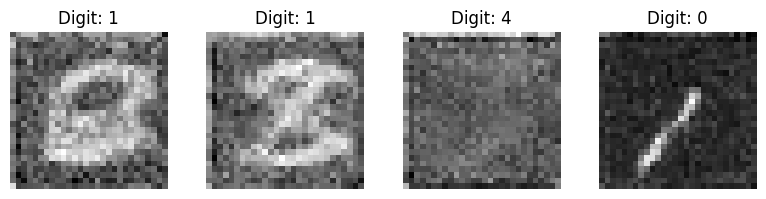

Epoch [2/1000], i: 0, Loss: 0.0205, Running loss: 0.02613505209128678
Epoch [2/1000], i: 50, Loss: 0.0363, Running loss: 0.027937795334585677
Epoch [2/1000], i: 100, Loss: 0.0223, Running loss: 0.02665751497771196
Epoch [2/1000], i: 150, Loss: 0.0270, Running loss: 0.025283787427511386
Epoch [2/1000], i: 200, Loss: 0.0247, Running loss: 0.02494571989716495
Epoch [2/1000], i: 250, Loss: 0.0232, Running loss: 0.022446638334373516
Epoch [2/1000], i: 300, Loss: 0.0213, Running loss: 0.02197298868824952
Epoch [2/1000], i: 350, Loss: 0.0188, Running loss: 0.02146029914334106
Epoch [2/1000], i: 400, Loss: 0.0242, Running loss: 0.022984168335187315
Epoch [2/1000], i: 450, Loss: 0.0194, Running loss: 0.02212598140251591
Epoch [3/1000], i: 0, Loss: 0.0214, Running loss: 0.021788429593068422
Epoch [3/1000], i: 50, Loss: 0.0229, Running loss: 0.02175648531130264
Epoch [3/1000], i: 100, Loss: 0.0189, Running loss: 0.02031349458155085
Epoch [3/1000], i: 150, Loss: 0.0191, Running loss: 0.02130117478

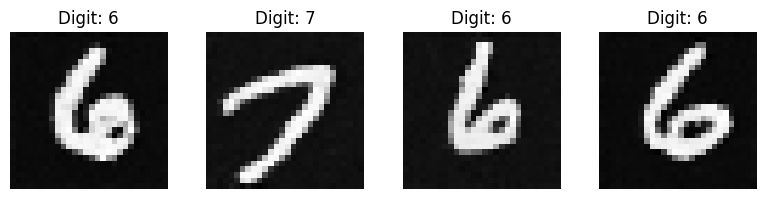

Epoch [7/1000], i: 0, Loss: 0.0163, Running loss: 0.015961906965316686
Epoch [7/1000], i: 50, Loss: 0.0205, Running loss: 0.017651493094314994
Epoch [7/1000], i: 100, Loss: 0.0163, Running loss: 0.016085325771932103
Epoch [7/1000], i: 150, Loss: 0.0137, Running loss: 0.01655182597533773
Epoch [7/1000], i: 200, Loss: 0.0185, Running loss: 0.016710194671653692
Epoch [7/1000], i: 250, Loss: 0.0166, Running loss: 0.016199214490611333
Epoch [7/1000], i: 300, Loss: 0.0171, Running loss: 0.016254201010157225
Epoch [7/1000], i: 350, Loss: 0.0131, Running loss: 0.0157839842433595
Epoch [7/1000], i: 400, Loss: 0.0168, Running loss: 0.016307218432860215
Epoch [7/1000], i: 450, Loss: 0.0151, Running loss: 0.015609039763009888
Epoch [8/1000], i: 0, Loss: 0.0170, Running loss: 0.014563282654192416
Epoch [8/1000], i: 50, Loss: 0.0180, Running loss: 0.015584743583161894
Epoch [8/1000], i: 100, Loss: 0.0137, Running loss: 0.015522817743499675
Epoch [8/1000], i: 150, Loss: 0.0137, Running loss: 0.015731

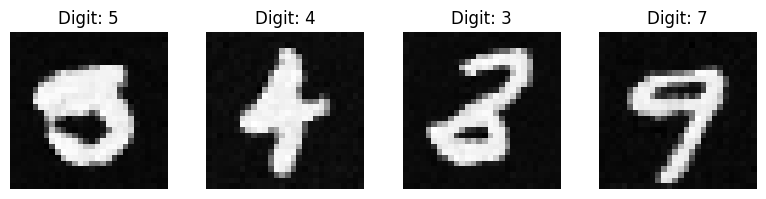

Epoch [12/1000], i: 0, Loss: 0.0140, Running loss: 0.015746526192905858
Epoch [12/1000], i: 50, Loss: 0.0165, Running loss: 0.015540579065895403
Epoch [12/1000], i: 100, Loss: 0.0177, Running loss: 0.016844297402847
Epoch [12/1000], i: 150, Loss: 0.0159, Running loss: 0.014473663791810022
Epoch [12/1000], i: 200, Loss: 0.0255, Running loss: 0.016565623707993415
Epoch [12/1000], i: 250, Loss: 0.0177, Running loss: 0.01549640921757445
Epoch [12/1000], i: 300, Loss: 0.0149, Running loss: 0.015476249020558571
Epoch [12/1000], i: 350, Loss: 0.0131, Running loss: 0.014854882989188184
Epoch [12/1000], i: 400, Loss: 0.0124, Running loss: 0.01490901935852322
Epoch [12/1000], i: 450, Loss: 0.0135, Running loss: 0.01542943494201454
Epoch [13/1000], i: 0, Loss: 0.0160, Running loss: 0.01388732990056113
Epoch [13/1000], i: 50, Loss: 0.0135, Running loss: 0.014631238369279168
Epoch [13/1000], i: 100, Loss: 0.0141, Running loss: 0.015679565711544892
Epoch [13/1000], i: 150, Loss: 0.0143, Running loss

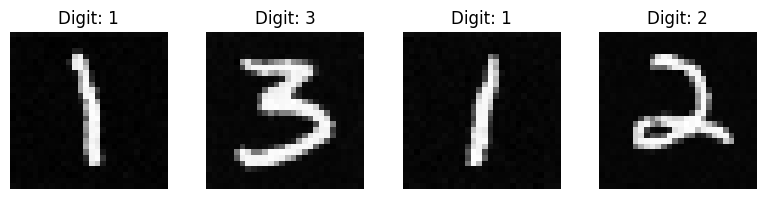

Epoch [17/1000], i: 0, Loss: 0.0117, Running loss: 0.013541578643560268
Epoch [17/1000], i: 50, Loss: 0.0126, Running loss: 0.014501020142874688
Epoch [17/1000], i: 100, Loss: 0.0154, Running loss: 0.015121654314271885
Epoch [17/1000], i: 150, Loss: 0.0128, Running loss: 0.014075306833716512
Epoch [17/1000], i: 200, Loss: 0.0155, Running loss: 0.014347105305877773
Epoch [17/1000], i: 250, Loss: 0.0143, Running loss: 0.013574570269183095
Epoch [17/1000], i: 300, Loss: 0.0150, Running loss: 0.014179404110567862
Epoch [17/1000], i: 350, Loss: 0.0148, Running loss: 0.014701974068651036
Epoch [17/1000], i: 400, Loss: 0.0178, Running loss: 0.015058914129064403
Epoch [17/1000], i: 450, Loss: 0.0159, Running loss: 0.015831056893583006
Epoch [18/1000], i: 0, Loss: 0.0134, Running loss: 0.014704295856273572
Epoch [18/1000], i: 50, Loss: 0.0151, Running loss: 0.014057495880762627
Epoch [18/1000], i: 100, Loss: 0.0159, Running loss: 0.014593129999560927
Epoch [18/1000], i: 150, Loss: 0.0172, Runni

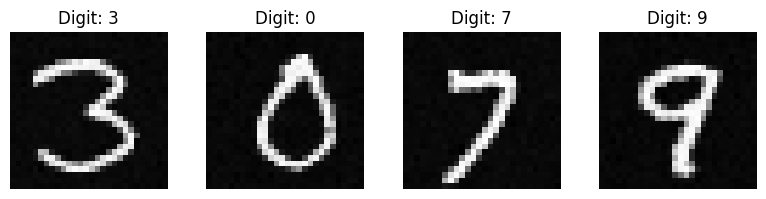

Epoch [22/1000], i: 0, Loss: 0.0172, Running loss: 0.013031404786224889
Epoch [22/1000], i: 50, Loss: 0.0142, Running loss: 0.014435363220919036
Epoch [22/1000], i: 100, Loss: 0.0184, Running loss: 0.014089681499401902
Epoch [22/1000], i: 150, Loss: 0.0181, Running loss: 0.014789709355966643
Epoch [22/1000], i: 200, Loss: 0.0107, Running loss: 0.014452424917808133
Epoch [22/1000], i: 250, Loss: 0.0128, Running loss: 0.01328743692853426
Epoch [22/1000], i: 300, Loss: 0.0162, Running loss: 0.014362158972521508
Epoch [22/1000], i: 350, Loss: 0.0122, Running loss: 0.014126194883354405
Epoch [22/1000], i: 400, Loss: 0.0184, Running loss: 0.014252027811106528
Epoch [22/1000], i: 450, Loss: 0.0144, Running loss: 0.014047989854590728
Epoch [23/1000], i: 0, Loss: 0.0139, Running loss: 0.014185931971030302
Epoch [23/1000], i: 50, Loss: 0.0163, Running loss: 0.014793149932343184
Epoch [23/1000], i: 100, Loss: 0.0152, Running loss: 0.014687937949918994
Epoch [23/1000], i: 150, Loss: 0.0133, Runnin

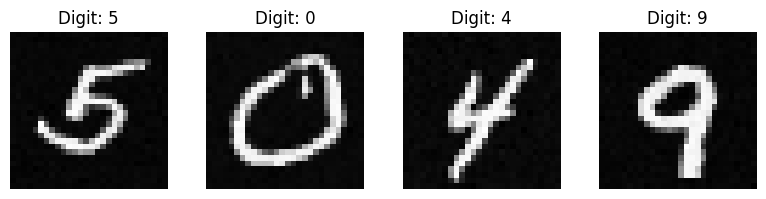

Epoch [27/1000], i: 0, Loss: 0.0119, Running loss: 0.013973070158219048
Epoch [27/1000], i: 50, Loss: 0.0135, Running loss: 0.013773304076051249
Epoch [27/1000], i: 100, Loss: 0.0157, Running loss: 0.014591612774737547
Epoch [27/1000], i: 150, Loss: 0.0146, Running loss: 0.01418157300671477
Epoch [27/1000], i: 200, Loss: 0.0153, Running loss: 0.0136704768106303
Epoch [27/1000], i: 250, Loss: 0.0125, Running loss: 0.013215565192719405
Epoch [27/1000], i: 300, Loss: 0.0113, Running loss: 0.013243509666417462
Epoch [27/1000], i: 350, Loss: 0.0142, Running loss: 0.014056667480621144
Epoch [27/1000], i: 400, Loss: 0.0132, Running loss: 0.014164312842505104
Epoch [27/1000], i: 450, Loss: 0.0136, Running loss: 0.013901413352204336
Epoch [28/1000], i: 0, Loss: 0.0121, Running loss: 0.014033385257619284
Epoch [28/1000], i: 50, Loss: 0.0133, Running loss: 0.013800497698648983
Epoch [28/1000], i: 100, Loss: 0.0140, Running loss: 0.013421913299434839
Epoch [28/1000], i: 150, Loss: 0.0142, Running 

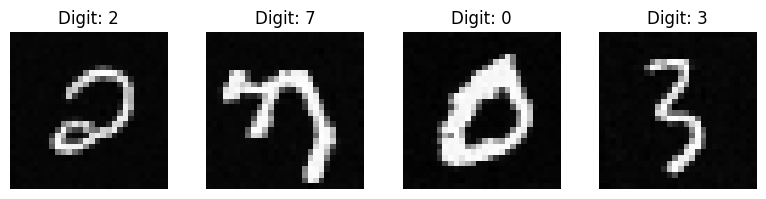

Epoch [32/1000], i: 0, Loss: 0.0137, Running loss: 0.013953841334525393
Epoch [32/1000], i: 50, Loss: 0.0148, Running loss: 0.0139190001475374
Epoch [32/1000], i: 100, Loss: 0.0135, Running loss: 0.01421618640676197
Epoch [32/1000], i: 150, Loss: 0.0141, Running loss: 0.014045739133301802
Epoch [32/1000], i: 200, Loss: 0.0119, Running loss: 0.013093556675049413
Epoch [32/1000], i: 250, Loss: 0.0100, Running loss: 0.013125604647360775
Epoch [32/1000], i: 300, Loss: 0.0149, Running loss: 0.014521109578621285
Epoch [32/1000], i: 350, Loss: 0.0160, Running loss: 0.014509918104140337
Epoch [32/1000], i: 400, Loss: 0.0107, Running loss: 0.014256756021203668
Epoch [32/1000], i: 450, Loss: 0.0207, Running loss: 0.013786708203494376
Epoch [33/1000], i: 0, Loss: 0.0116, Running loss: 0.013410342198728494
Epoch [33/1000], i: 50, Loss: 0.0151, Running loss: 0.014024000085752183
Epoch [33/1000], i: 100, Loss: 0.0136, Running loss: 0.014011829783457271
Epoch [33/1000], i: 150, Loss: 0.0167, Running 

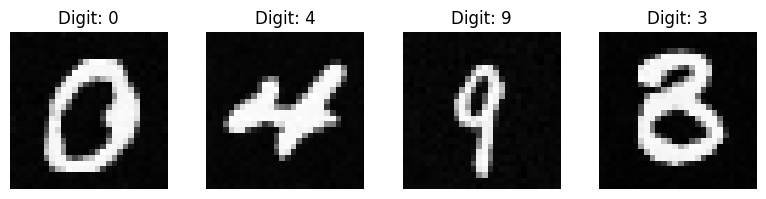

Epoch [37/1000], i: 0, Loss: 0.0112, Running loss: 0.012898606008833663
Epoch [37/1000], i: 50, Loss: 0.0128, Running loss: 0.013158427082933275
Epoch [37/1000], i: 100, Loss: 0.0117, Running loss: 0.013150951158261846
Epoch [37/1000], i: 150, Loss: 0.0126, Running loss: 0.013450307512305908
Epoch [37/1000], i: 200, Loss: 0.0133, Running loss: 0.013606733613968962
Epoch [37/1000], i: 250, Loss: 0.0154, Running loss: 0.01445415690706012
Epoch [37/1000], i: 300, Loss: 0.0156, Running loss: 0.013346079478596232
Epoch [37/1000], i: 350, Loss: 0.0137, Running loss: 0.013548316007479248
Epoch [37/1000], i: 400, Loss: 0.0143, Running loss: 0.014360304201336173
Epoch [37/1000], i: 450, Loss: 0.0119, Running loss: 0.013811198401712311
Epoch [38/1000], i: 0, Loss: 0.0156, Running loss: 0.013909039125868864
Epoch [38/1000], i: 50, Loss: 0.0179, Running loss: 0.01504508915286455
Epoch [38/1000], i: 100, Loss: 0.0117, Running loss: 0.013988436816456212
Epoch [38/1000], i: 150, Loss: 0.0185, Running

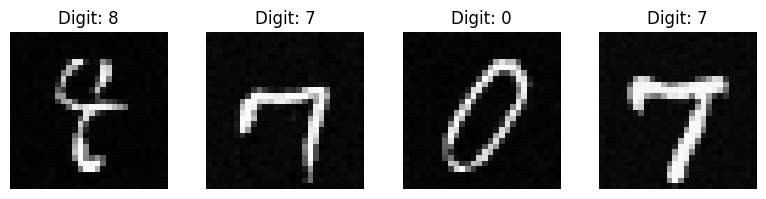

Epoch [42/1000], i: 0, Loss: 0.0162, Running loss: 0.013436238385921255
Epoch [42/1000], i: 50, Loss: 0.0131, Running loss: 0.014130604225048493
Epoch [42/1000], i: 100, Loss: 0.0109, Running loss: 0.012830734373924362
Epoch [42/1000], i: 150, Loss: 0.0157, Running loss: 0.014414149452069733
Epoch [42/1000], i: 200, Loss: 0.0135, Running loss: 0.013607794051745224
Epoch [42/1000], i: 250, Loss: 0.0115, Running loss: 0.013239948993105221
Epoch [42/1000], i: 300, Loss: 0.0146, Running loss: 0.013020870316273149
Epoch [42/1000], i: 350, Loss: 0.0153, Running loss: 0.013607804234010411
Epoch [42/1000], i: 400, Loss: 0.0121, Running loss: 0.013160364218879061
Epoch [42/1000], i: 450, Loss: 0.0126, Running loss: 0.01396480554835556
Epoch [43/1000], i: 0, Loss: 0.0140, Running loss: 0.013374750970834112
Epoch [43/1000], i: 50, Loss: 0.0148, Running loss: 0.013220949228429523
Epoch [43/1000], i: 100, Loss: 0.0141, Running loss: 0.013616777542497481
Epoch [43/1000], i: 150, Loss: 0.0149, Runnin

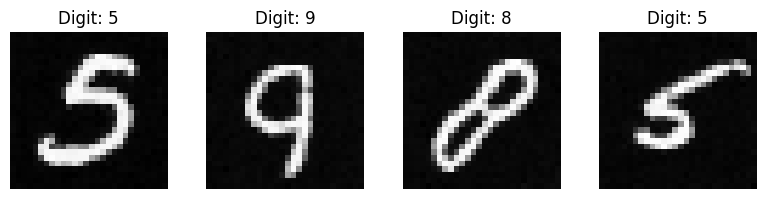

Epoch [47/1000], i: 0, Loss: 0.0146, Running loss: 0.013354573150088471
Epoch [47/1000], i: 50, Loss: 0.0136, Running loss: 0.012185209813064852
Epoch [47/1000], i: 100, Loss: 0.0100, Running loss: 0.013279396694391085
Epoch [47/1000], i: 150, Loss: 0.0180, Running loss: 0.013572020631456648
Epoch [47/1000], i: 200, Loss: 0.0124, Running loss: 0.013109224985534702
Epoch [47/1000], i: 250, Loss: 0.0121, Running loss: 0.013122728528891136
Epoch [47/1000], i: 300, Loss: 0.0112, Running loss: 0.012927206479221248
Epoch [47/1000], i: 350, Loss: 0.0130, Running loss: 0.013069486014558235
Epoch [47/1000], i: 400, Loss: 0.0121, Running loss: 0.013505821736678046
Epoch [47/1000], i: 450, Loss: 0.0145, Running loss: 0.013184553526809554
Epoch [48/1000], i: 0, Loss: 0.0108, Running loss: 0.012984225370126301
Epoch [48/1000], i: 50, Loss: 0.0144, Running loss: 0.01367517509224933
Epoch [48/1000], i: 100, Loss: 0.0123, Running loss: 0.013950228270669407
Epoch [48/1000], i: 150, Loss: 0.0130, Runnin

KeyboardInterrupt: 

In [30]:
train(epochs)

In [33]:
wandb.finish()

avg_running_loss,▁█▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
latest_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_running_loss,0.03641
latest_loss,0.03718
